In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from metrics import accuracy

from sklearn import datasets
from sklearn.model_selection import train_test_split

# <span style="color:#F08E21">Support Vector Machine (SVM)</span>

Is a versatile and powerful ML model and can perform both linear and non-linear classification, regression or outlier detection.\
They can be particularly well-suited to classification for complex but small to medium sized datasets.\
SVM is sensitive to feature scales -> Scaling can be of benefit.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2020/10/svm-all.png" alt="Image of SVM" style="background-color:white;">

### <span style="color:#217AB8">Linear Classification with SVM</span>
Set the boundary between classes so as to keep the largest margin between them, or placing the widest possible street between the classes. -> large margin classification.\
The decision boundary is determined/supported by the instances located on the edge of the street (named the support vectors). If you added more data that is beyond the street it would change nothing about the decision boundary.

The decision funciton is $w^T * X + b$\
If $\hat y >= 0$ then $1$ else $0$

Task find the w and b that make the margin as wide as possible. This can be achieved by minimizing $||w||$.

**&emsp;Soft vs Hard Margin Classification**\
&emsp; Hard margin: If all instances must be off the street and on the right side. (Using the constrained optimization problem)\
&emsp; Downsides: Only works with linearly seperable data and is very sensitive to outliers.\
&emsp; Minimize $\frac{1}{2}* w^T*w$ with constraint $t^{(i)}(w^T*x^{(i)}+b) >= 1$ where $t = -1$ for negative instances and $t = 1$ for positive instances

&emsp; Soft-margin: Find a balance between keeping the street as wide as possible and limit the margin violations.\
&emsp; A slightly more flexible model that may generalize better.\
&emsp; Minimize $\frac{1}{2}*w^T*w + C * sum_{i=1}^m(z)$ with constraint $t^{(i)}(w^T*x^{(i)}+b) >= 1-z$ (z = slack variable, t same as above)

&emsp; By controlling the width of the street eg. c variable the number of margin violations can be increased or decreased. (eg. scikit-learn high c lower margin violation)

In [2]:
class LinearSVC:
    # linear SVM Classification
    # with hinge loss
    def __init__(self, lr=0.01, c=1, reg=0.01, n_iter=1000):
        self.lr = lr
        self.c = c
        self.reg = reg
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        y_corr = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iter):
            for id, x in enumerate(X):
                condition = y_corr[id] * (np.dot(x, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * 2 * self.reg * self.weights
                else:
                    self.weights -= self.lr * 2 * self.reg * self.weights - np.dot(y_corr[id], x)
                    self.bias -= self.lr * y_corr[id]



    def predict(self, X):
        linear = np.dot(X, self.weights) - self.bias
        return np.sign(linear)


In [3]:
X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.05, random_state=23)
y = np.where(y <= 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [4]:
lin_svc = LinearSVC()
lin_svc.fit(X_train,y_train)

predicted = lin_svc.predict(X_test)
accuracy(predicted, y_test)

1.0

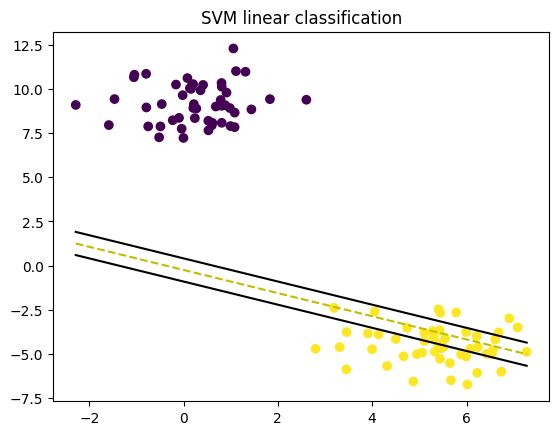

In [5]:
def get_hyperplane(x,w,b,offset):
    return (-w[0] + x + b + offset) / w[1]


def visualize_svm():
    plt.scatter(X[:,0], X[:,1], marker='o', c=y)
    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])
    
    x1_1 = get_hyperplane(x0_1, lin_svc.weights, lin_svc.bias, 0)
    x1_2 = get_hyperplane(x0_2, lin_svc.weights, lin_svc.bias, 0)

    x1_1_n = get_hyperplane(x0_1, lin_svc.weights, lin_svc.bias, -1)
    x1_2_n = get_hyperplane(x0_2, lin_svc.weights, lin_svc.bias, -1)

    x1_1_p = get_hyperplane(x0_1, lin_svc.weights, lin_svc.bias, 1)
    x1_2_p = get_hyperplane(x0_2, lin_svc.weights, lin_svc.bias, 1)

    plt.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
    plt.plot([x0_1, x0_2], [x1_1_n, x1_2_n], 'k')
    plt.plot([x0_1, x0_2], [x1_1_p, x1_2_p], 'k')
    plt.title("SVM linear classification")
    plt.show()

visualize_svm()

In [6]:
class LinearSVR:
    # linear SVM Regression
    def __init__(self):
        pass

    def fit(self, X, y):
        pass

    def predict(self, X, y):
        pass


### <span style="color:#217AB8">Non-Linear Classification with SVM</span>
When the instances can not be separated by a linear decision boundary SVM makes use of non-linear methods.

Kernels in ML:\
A kernel is a function that is capable of computing the dot product $t(a)^T \cdot t(b)$ without needing to know about the t() transformation function.\
Some Kernels respect Mercer's conditions while sigmoid does not.(it does however still perform well enough)\
Examples: 
* Linear: $K(a,b) = a^T \cdot b$
* Polynomial: $K(a,b) = (\gamma a^T \cdot b + r)^d$
* Gaussian RBF: $K(a,b) = \exp(-\gamma ||a - b||^2)$
* Sigmoid: $K(a,b) = tanh(\gamma a^T \cdot b +r)$

Kernel trick:\
Using the dual problem solution the transformation of two vectors and subsequent dot product is the same as the squared dot product.\
For example: $trans(a)^T \cdot trans(b) = (a^T \cdot b)^2$ - a $2^{nd}$ degree plynomial kernel.\
This allows us to use the features as are while still getting the same effect as if they had been transformed quadratically.

**&emsp;Polynomial Kernel**\
&emsp;Using the technique called the kernel trick it possible to get the same results as adding many polynomial features to your dataset, without actually having to add them.\
&emsp;Setting the polynomial to high can lead to overfitting, while setting it too low can lead to underfitting (eg. attempting linear boundaries with non-linear classes)

**&emsp;Similarity Features**\
&emsp;Add features computed using a similarity function that measures how similar an instance is to a landmark.\
&emsp;An example of such a similarity function could be the Gaussian Radial Bias Function (RBF) which is a bell shaped function where 0 means the instance is far away from the landmark and 1 means it is right on top.\
&emsp;Applying this function and using it as the features to describe the data set makes the instances linearly separable. (selecting the landmarks close to each instance makes it more likely to become linearly separable.\
&emsp;However this explodes the dataset to have as many features as samples)\
&emsp;Again the Kernel trick can help you achieve the same complexity without adding so many new features.

### <span style="color:#217AB8">Regression with SVM</span>
Here the idea of the street is reversed: For regression as many instances as possible should fit on the street and margin violations (here off the street) should be minimized.
Epsilon determines the margin and adding new instances within the street does not affect the margin.
The linear and non-linear aspects are very similar to the classification examples.